# Character Classification with Neural Networks

In this notebook we are going to use the Neural Networks for image classification. We are going to use the same dataset of the lab on SVM: Kuzushiji-MNIST or K-MNIST for short (https://github.com/rois-codh/kmnist) a dataset of traditional japanese handwritten kana.

The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

In [1]:
#load the required packages and check Scikit-learn version

%matplotlib inline  

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import sklearn
print ('scikit-learn version: ', sklearn.__version__)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

scikit-learn version:  1.0.2


In [2]:
# helper function to load KMNIST dataset from disk
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

In [3]:
num = 2072050
np.random.seed(num)

In [4]:
#load the MNIST dataset and let's normalize the features so that each value is in [0,1]
X, y = load_mnist("data")
print("Number of samples in the K-MNIST dataset:", X.shape[0])
# rescale the data
X = X / 255.0

Number of samples in the K-MNIST dataset: 60000


Now split into training and test. We start with a small training set of 600 samples to reduce computation time while 4000 samples will be used for testing. Make sure that each label is present at least 10 times in train and test set frequencies.

In [5]:
#random permute the data and split into training and test taking the first 600
#data samples as training and 4000 as test set
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 600
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

labelsT, freqsT = np.unique(y_test, return_counts=True)
print("Labels in test set: ", labels)
print("Frequencies in test set: ", freqs)


Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [73 50 65 49 60 60 61 66 64 52]
Labels in test set:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in test set:  [73 50 65 49 60 60 61 66 64 52]


In [6]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    print("LABEL: %i"%labels[index])
    return

INPUT:


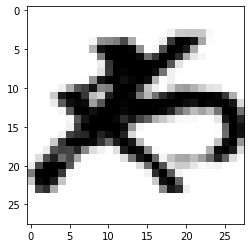

LABEL: 7
INPUT:


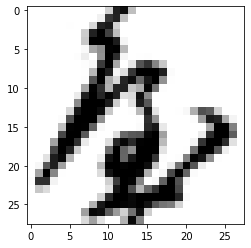

LABEL: 7
INPUT:


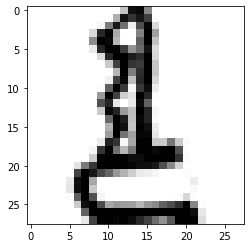

LABEL: 8


In [7]:
#let's try the plotting function
plot_input(X_train,y_train,10)
plot_input(X_test,y_test,100)
plot_input(X_test,y_test,1000)


Now use a feed-forward Neural Network for prediction. Use the multi-layer perceptron classifier, with the following parameters: max_iter=100, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1, random_state=ID (this last parameter ensures the run is the same even if you run it more than once). The alpha parameter is the regularization term.

Then, using the default activation function, pick four or five architectures to consider, with different numbers of hidden layers and different sizes. It is not necessary to create huge neural networks, you can limit to 3 layers and, for each layer, its maximum size can be of 50. Evaluate the architectures you chose using GridSearchCV with cv=5.


In [8]:
# these are sample values but feel free to change them as you like, try to experiment with different sizes!!
parameters = {'hidden_layer_sizes': [(10,), (20,), (40,), (20,20,), (40,20,10) ]}

#I used max_iter = 1000 because my computer was able to compute it and also I don't like red warnings

mlp = MLPClassifier(max_iter=1000, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=num,
                    learning_rate_init=.1)



clf = GridSearchCV(mlp, parameters, cv=5)
clf.fit(X_train,y_train)

print ('RESULTS FOR NN\n')

print("Best parameters set found:", clf.best_params_)

print("Score with best parameters:", clf.best_score_)

print("\nAll scores on the grid:", clf.cv_results_['mean_test_score'])

RESULTS FOR NN

Best parameters set found: {'hidden_layer_sizes': (40,)}
Score with best parameters: 0.76

All scores on the grid: [0.66333333 0.72666667 0.76       0.695      0.69      ]



Now try also different batch sizes, while keeping the best NN architecture you have found above. Remember that the batch size was previously set to the default value, i.e., min(200, n_samples). 
Recall that a batch size of 1 corresponds to baseline SGD, while using all the 480 training samples (there are 600 samples but in cross validation with 5 folders we use 1/5 of them for validation at each round) corresponds to standard GD and using a different mini-batch size lies in the middle between the two extreme cases.

In [9]:
# these are sample values corresponding to baseline SGD, a reasonable mini-batch size and standard GD
# again feel free to change them as you like, try to experiment with different batch sizes!!
parameters = {'batch_size': [1, 32, 480]}

# need to specify that you would like to use the standard k-fold split otherwise sklearn create splits of different sizes
kf = sklearn.model_selection.KFold(n_splits=5)


mlp2 = MLPClassifier(max_iter=1000, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=num,
                    learning_rate_init=.1, hidden_layer_sizes=(40,))

# recall to use cv=kf to use the k-fold subdivision seen in the lectures

clf2 = GridSearchCV(mlp2, parameters, cv=kf)
clf2.fit(X_train,y_train)



print ('RESULTS FOR NN\n')

print("Best parameters set found:", clf2.best_params_)

print("Score with best parameters:", f"{clf.best_score_:.6}")

print("\nAll scores on the grid:", clf2.cv_results_['mean_test_score'])

RESULTS FOR NN

Best parameters set found: {'batch_size': 480}
Score with best parameters: 0.76

All scores on the grid: [0.10333333 0.75833333 0.76333333]


The best performance is with (40,).
The difference of performance between batch size = 32 and batch size = 480 is not so significant.

Plot the train and test accuracies as a function of the number of learnable parameters in your neural network. Print also the computation time for the various configurations you try (the code for getting the computation time is already provided). You can use 100 iterations (if you get a warning on convergence not reached it is not an issue for this lab)

Training MLP of size (10,) ...
Done, training time: 0.81 sec

Training MLP of size (20,) ...
Done, training time: 0.69 sec

Training MLP of size (40,) ...
Done, training time: 0.76 sec

Training MLP of size (20, 20) ...
Done, training time: 0.56 sec

Training MLP of size (40, 20, 10) ...
Done, training time: 0.87 sec



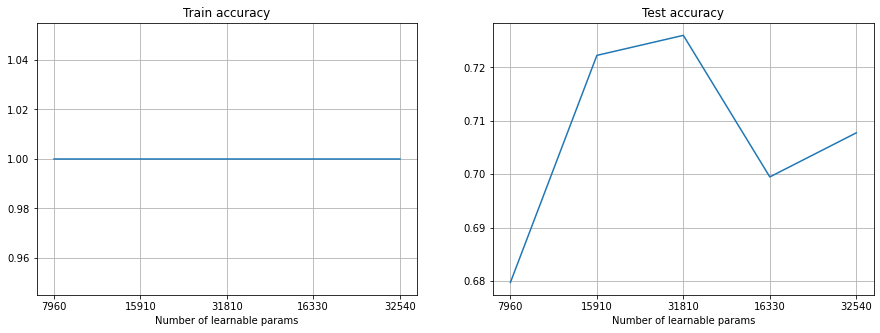

In [10]:
import time
from functools import reduce

# Function to compute the number of learnable parameters of a mlp given the size of its hidden layers
def param_count(hl_size):
    tot = 0
    input_size, output_size = X_train.shape[1], len(labels)
    tot += (input_size+1)*hl_size[0]
    for i in range(1,len(hl_size)):
        tot += (hl_size[i-1]+1)*hl_size[i]
    tot += (hl_size[-1]+1)*output_size
    return tot

hl_sizes = [(10,), (20,), (40,), (20,20,), (40,20,10)]
hl_labels = [param_count(t) for t in hl_sizes]

ti = time.time()
train_acc_list, test_acc_list = [], []
for hl_size in hl_sizes:
    print('Training MLP of size {} ...'.format(hl_size))
    mlp = MLPClassifier(max_iter=1000, alpha=1e-4, solver='sgd', tol=1e-4, random_state=num,
                        learning_rate_init=.1, hidden_layer_sizes=hl_size, batch_size=480)
    mlp.fit(X_train, y_train)
    
    
    train_acc_list.append(mlp.score(X_train, y_train))
    test_acc_list.append(mlp.score(X_test, y_test))
    print('Done, training time: {:.2f} sec\n'.format(time.time()-ti))
    ti = time.time()

fig, ax = plt.subplots(1,2, figsize=(15,5))


ax[0].plot(train_acc_list)
ax[0].set_xlabel('Number of learnable params')
ax[0].set_title('Train accuracy')
ax[0].set_xticks(np.arange(0,len(hl_labels)))
ax[0].set_xticklabels(hl_labels)
ax[0].grid(True)

ax[1].plot(test_acc_list)
ax[1].set_xlabel('Number of learnable params')
ax[1].set_title('Test accuracy')
ax[1].set_xticks(np.arange(0,len(hl_labels)))
ax[1].set_xticklabels(hl_labels)
ax[1].grid(True)


Training accuracy doesn't change with the change of learnable parameters, it means that we are able to fit all 600 samples perfectly.

However, having too much parameters causes overfitting. We see on the right plot that firstly test accuracy was growing, then after 31810 it dropped, but in the end we still can see growth. So maybe in this particular case overfitting is not a problem, however we can take a number of learnable parameters that correspond to a peak, as for our chosen architectures it is the best result (even though maybe there are better solutions that we did not consider and that do not cause overfitting).

Now try also to use different learning rates, while keeping the best NN architecture and batch size you have found above. Plot the learning curves (i.e., the variation of the loss over the steps, you can get it from the loss_curve_ object of sklearn) for the different values of the learning rate. Try to run each training for 100 iterations. 

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


RESULTS FOR NN

All learning rates and their scores: {0.0002: 0.24125, 0.002: 0.65875, 0.02: 0.72225, 0.2: 0.7315}
Best parameters set found: 0.7315
Score with best parameters: 0.2


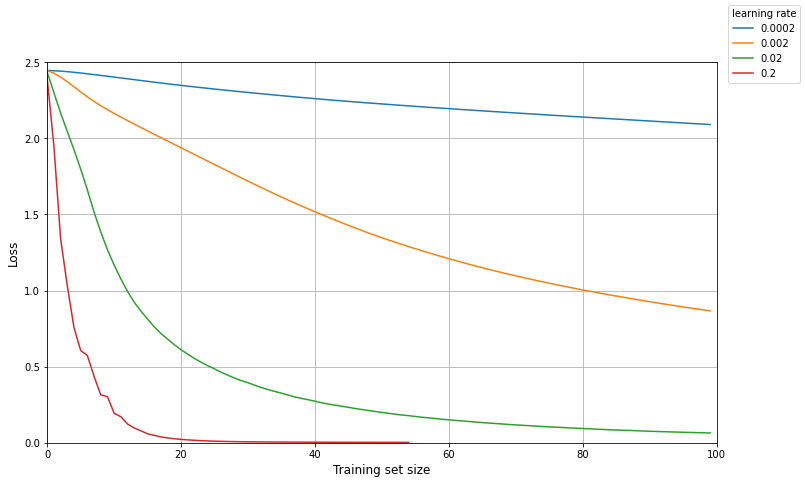

In [11]:
import matplotlib.pyplot as plt
import operator

lr_list = [0.0002, 0.002, 0.02, 0.2]
scores = {}
mlps = []


for rate in lr_list:
    mlp3 = MLPClassifier(max_iter=100, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=num,
                    hidden_layer_sizes=(40,), batch_size=480, learning_rate_init=rate)
    mlp3.fit(X_train,y_train)
    mlps.append(mlp3)
    scores[rate]=mlp3.score(X_test, y_test)


print ('RESULTS FOR NN\n')

print("All learning rates and their scores:", scores)

print("Best parameters set found:", max(scores.values()))

print("Score with best parameters:", list(scores.keys())[list(scores.values()).index(max(scores.values()))])

fig, ax = plt.subplots(figsize=(12,7))
for mlp, label in zip(mlps, scores.keys()):
        ax.plot(mlp.loss_curve_,label=label)
fig.legend(scores.keys(),loc='upper right',title='learning rate')
ax.set_xlim(0,100)
ax.set_ylim(0,2.5)
ax.set_ylabel('Loss',size=12)
ax.set_xlabel('Training set size',size=12)
ax.grid(True)


NN with the biggest learning rate can reach its convergence faster (red curve). For others it will take more samples to reach it (speed of convergence is slower).
However, with learning rate = 0.2 we can see some unsmoothness in the region between 0 and 20 training set sizes. Other lines remain smooth everywhere.

Now get training and test error for a NN with best parameters (architecture, batch size and learning rate) from above. Plot the learning curve also for this case (you can run the training for 500 iterations).

In [12]:
#get training and test error for the best NN model from CV
from sklearn.model_selection import cross_val_score


mlp_best = MLPClassifier(max_iter=500, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=num,
                    hidden_layer_sizes=(40,), batch_size=480, learning_rate_init=0.2)
mlp_best.fit(X_train,y_train)


training_error = 1 - mlp_best.score(X_train,y_train)
test_error = 1 - mlp_best.score(X_test, y_test)
print ('\nRESULTS FOR BEST NN\n')

print ("Best NN training error: %f" % training_error)
print ("Best NN test error: %f" % test_error)




RESULTS FOR BEST NN

Best NN training error: 0.000000
Best NN test error: 0.268500


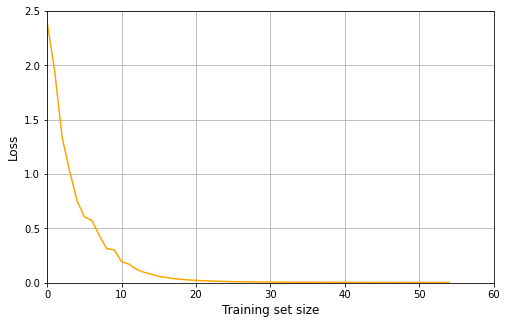

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(mlp_best.loss_curve_,label=label, color='orange')
ax.set_xlim(0,60)
ax.set_ylim(0,2.5)
ax.set_ylabel('Loss',size=12)
ax.set_xlabel('Training set size',size=12)
ax.grid(True)

## More data 
Now let's do the same but using 4000 (or less if it takes too long on your machine) data points for training. Use the same NN architecture as before.

In [14]:
X = X[permutation]
y = y[permutation]

m_training = 4000

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [413 371 436 434 379 399 371 397 397 403]


In [15]:
# use best architecture and params from before
mlp_best2 = MLPClassifier(max_iter=1000, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=num,
                    hidden_layer_sizes=(40,), batch_size=480, learning_rate_init=0.2)
mlp_best2.fit(X_train,y_train)


training_error = 1 - mlp_best2.score(X_train,y_train)
test_error = 1 - mlp_best2.score(X_test, y_test)

print ('\nRESULTS FOR NN\n')

#get training and test error for the NN

print ("NN training error: %f" % training_error)
print ("NN test error: %f" % test_error)



RESULTS FOR NN

NN training error: 0.000000
NN test error: 0.147661


Training error remains zero, while test error became almost 2 times lower. As expected, our model is better trained with more samples.

Plot an example that was missclassified by NN with m=600 training data points and it is now instead correctly classified by NN with m=4000 training data points.

The sample misclassified by NN with m = 600
INPUT:


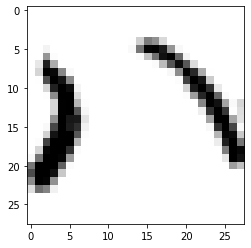

LABEL: 3


Classification by NN with m = 4000
INPUT:


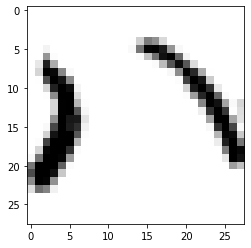

LABEL: 6


True classification
INPUT:


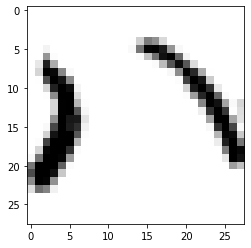

LABEL: 6


In [16]:
Y_600 = mlp_best.predict(X_test)
Y_4000 = mlp_best2.predict(X_test)

for i in range(len(Y_600)):
    if (Y_600[i] != y_test[i]) and (Y_4000[i] == y_test[i]):
        index = i
        break

print("The sample misclassified by NN with m = 600")
plot_input(X_train,Y_600,index)
print('\n')
print("Classification by NN with m = 4000")
plot_input(X_train,Y_4000,index)
print('\n')
print("True classification")
plot_input(X_train,y_test,index)       


Let's plot the weigths of the multi-layer perceptron classifier, for the best NN we get with 600 data points and with 4000 data points. The code is already provided, just fix variable names (e.g., replace mlp , mlp_large with your estimators) in order to have it working with your implementation



Weights with 600 data points:


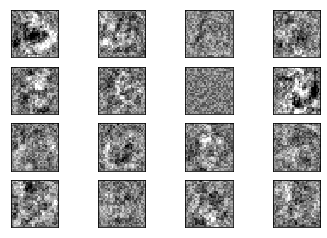

Weights with 4000 data points:


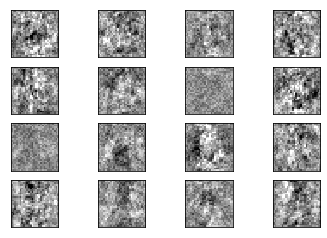

In [17]:
print("Weights with 600 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp_best.coefs_[0].min(), mlp_best.coefs_[0].max()
for coef, ax in zip(mlp_best.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

print("Weights with 4000 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp_best2.coefs_[0].min(), mlp_best2.coefs_[0].max()
for coef, ax in zip(mlp_best2.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

Take the best SVM model and its parameters, you found in the last notebook. Fit it on a few data points and compute its training and test scores. Then fit also a logistic regression model with C=1. 

In [18]:
m_training = 5000

X_train, X_test = X[:m_training], X[m_training:2*m_training]
y_train, y_test = y[:m_training], y[m_training:2*m_training]

# use best parameters found in the SVM notebook, create SVM and perform fitting
from sklearn.svm import SVC
best_SVM = SVC(kernel='rbf', C=10, gamma = 0.01)
best_SVM.fit(X_train,y_train)

print ('RESULTS FOR SVM')

SVM_training_error =  1 - best_SVM.score(X_train, y_train)

print("Training error SVM:")
print(SVM_training_error)

SVM_test_error = 1 - best_SVM.score(X_test, y_test)
print("Test error SVM:")
print(round(SVM_test_error,5))

RESULTS FOR SVM
Training error SVM:
0.0
Test error SVM:
0.0808


In [19]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score

logreg = linear_model.LogisticRegression(C=1, max_iter=5000)
learning = logreg.fit(X_train,y_train)

print ('\nRESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION')

prediction_train = learning.predict(X_train)
prediction_test = learning.predict(X_test)

training_error = 1 - accuracy_score(prediction_train, y_train)
test_error = 1 - accuracy_score(prediction_test, y_test)

print ("Training error (reg): %f" % training_error)
print ("Test error (reg): %f" % test_error)


RESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION
Training error (reg): 0.027400
Test error (reg): 0.237200


Test errors:
- Logistic regression: 0.24
- NN: 0.15
- SVM: 0.08

We can conclude that for our case SVM showed the best result. However, the second best is NN.

There is several ways to improve NN results.
Firstly, the most obvious way is to take more data. It was seen that taking more data improved the performance.
Secondly, we saw that on a plot with learnable parameters the curve starts to grow again. It can be that our best number of parameters led only to a local maximum on a plot and maybe we can increase them and receive a better test accuracy as well.
Thirdly, we can increase size of a hidden layer (it also leads to a larger amount of learnable parameters).


We can increase a size of a training set to 80% of all available data and took a hidden_layer_sizes equal to (50,). And with that simple "upgrade" I received a slightly better test error than SVM's: it became 0.07. If we compare it now to the previous result for NN, then we can see that the test error became 2 times less.

In [20]:
X = X[permutation]
y = y[permutation]

m_training = 48000

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

mlp_best3 = MLPClassifier(max_iter=5000, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=num,
                    hidden_layer_sizes=(50,), batch_size=480, learning_rate_init=0.2)
mlp_best3.fit(X_train,y_train)


training_error = 1 - mlp_best3.score(X_train,y_train)
test_error = 1 - mlp_best3.score(X_test, y_test)

print ('\nRESULTS FOR NN\n')

print ("NN training error: %f" % training_error)
print ("NN test error: %f" % test_error)


RESULTS FOR NN

NN training error: 0.000000
NN test error: 0.072167
